# 1. Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
df_train=pd.read_csv('/datasets/gold_recovery_train.csv')

In [3]:
df_test=pd.read_csv('/datasets/gold_recovery_test.csv')

In [4]:
df_full=pd.read_csv('/datasets/gold_recovery_full.csv')

In [5]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Как видим, много данных имеют пропуски. Будем проводить все замены в общей таблице, затем в последнем этапе обновим данные на исправленные в обучающей и тестовой выборке.  
Рассчитаем MAE для оценки эффективности на начальной и финальной стадии.

In [6]:
def recovery(tail,feed,concentrate):
    return (concentrate*(feed-tail)) / (feed*(concentrate-tail) )* 100

In [7]:
df_full['recovery_rougher']=recovery(df_full['rougher.output.tail_au'],df_full['rougher.input.feed_au'],df_full['rougher.output.concentrate_au'])

In [8]:
df_full['recovery_final']=recovery(df_full['final.output.tail_au'],df_full['rougher.input.feed_au'],df_full['final.output.concentrate_au'])

In [9]:
df_full['MAE_fin']=abs(df_full['final.output.recovery']-df_full['recovery_final']) / 2

In [10]:
df_full['MAE_rou']=abs(df_full['rougher.output.recovery']-df_full['recovery_rougher']) / 2

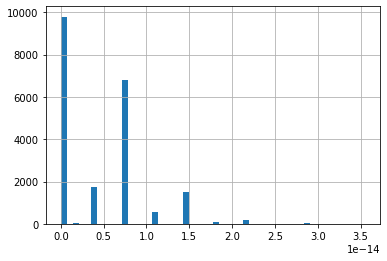

In [11]:
df_full['MAE_fin'].hist(bins=50)

In [12]:
df_full['MAE_fin'].mean()

4.257459948869043e-15

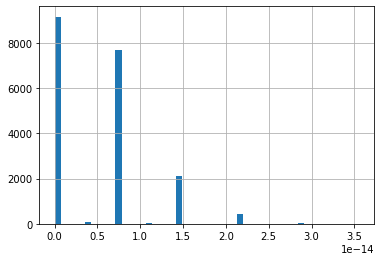

In [13]:
df_full['MAE_rou'].hist(bins=50)

In [14]:
df_full['MAE_rou'].mean()

4.908098443891756e-15

Как видим, значение ошибки можно считать равным 0. Так же у нас есть пропуски в эффективности, можем заполнить их применив формулу.

In [15]:
df_full['rougher.output.recovery']=df_full['recovery_rougher']

In [16]:
df_full['final.output.recovery']=df_full['recovery_final']

###### Проанализируем признаки в тестовой и обучающей выборке

In [17]:
df_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [18]:
df_test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

В тестовой выборке отсутствиуют столбцы содержащие информацию по параметрам продукта, в то время как в обучающей есть все столбцы. Все данные у нас представленны вещественными числами, кроме даты. Ее можно использовать как индекс, чтобы в дальнейшем объединять и редактировать таблицы

In [19]:
for df in (df_full,df_test,df_train):
    df['date']=pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
    df.set_index('date',inplace=True)

Выборки взятя из разных временных промежутков, имеют разные признаки. Т.к. для обучения модели нам нужны данные сырья приходящего на флотацию, режимы работы установки предполагаемые и химикаты. По этим данным модель должна будет сказать предполагаемое значение эффективности обогащения.

# 2. Анализ данных

### Проверим, как меняются концентрации веществ на разных стадиях

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
y_ag=df_full['rougher.output.concentrate_ag']
y1_ag=df_full['primary_cleaner.output.concentrate_ag']
y2_ag=df_full['final.output.concentrate_ag']
y_pb=df_full['rougher.output.concentrate_pb' ]
y1_pb=df_full['primary_cleaner.output.concentrate_pb']
y2_pb=df_full['final.output.concentrate_pb']
y_au=df_full['rougher.output.concentrate_au']
y1_au=df_full['primary_cleaner.output.concentrate_au']
y2_au=df_full['final.output.concentrate_au']

In [22]:
list_ag=y_ag,y1_ag,y2_ag
list_pb=y_pb,y1_pb,y2_pb
list_au=y_au,y1_au,y2_au

In [23]:
def histog(list):
    for i in list:
        i.hist(bins=50)
    plt.show()

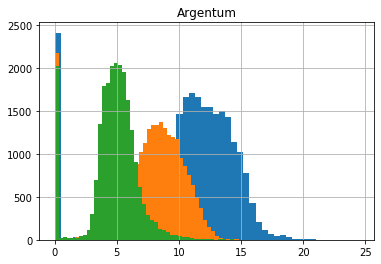

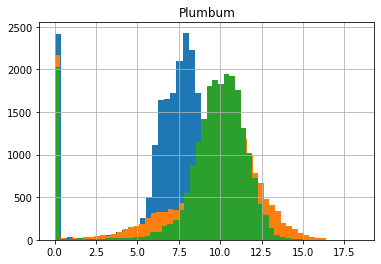

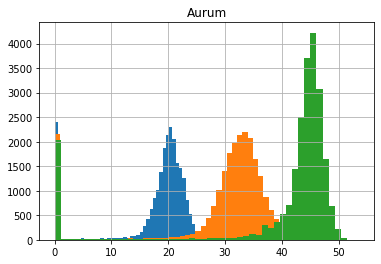

In [24]:
for list, name in zip((list_ag,list_pb,list_au),('Argentum', 'Plumbum','Aurum')):
    plt.title(name)
    histog(list)

Как видим, проходя по стадиям отчистки концентрация серебра падает с 15 до 5, содержание свинца сильно не меняется и остается в пределах 10, а вот концентрация золота раствет и меняется с 20 на стадии флотации до 30 на первичной отчистке и доходит до 45 к финальной.

Так же мы видим странные значения около 0, эти данные мы проанализируем далее

### Размеры гранул

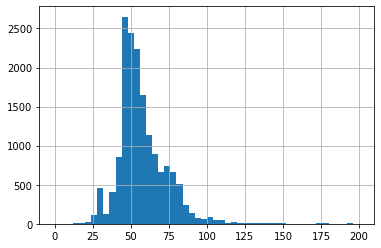

In [25]:
df_train['rougher.input.feed_size'].hist(bins=50,range=(0,200))

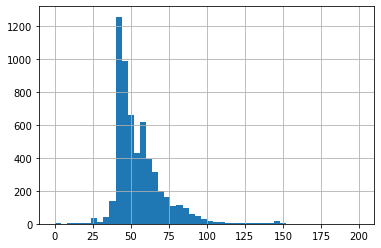

In [26]:
df_test['rougher.input.feed_size'].hist(bins=50,range=(0,200))

Распределение гранул очень схожее, можно его данные выборки рассматривать как равноценные

### Исследуем суммарную концентрацию веществ на разынх стадиях

In [27]:
df_full.isna().mean().sort_values(ascending=False).head(10)

MAE_rou                               0.137304
recovery_rougher                      0.122205
rougher.output.recovery               0.122205
rougher.output.tail_ag                0.120488
rougher.output.tail_sol               0.120444
rougher.output.tail_au                0.120444
rougher.input.floatbank11_xanthate    0.099357
secondary_cleaner.output.tail_sol     0.097508
MAE_fin                               0.086415
rougher.calculation.au_pb_ratio       0.071624
dtype: float64

Мы видим много пропусков в данных, давайте посмотрим в чем дело.

In [28]:
df_full.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

Рассмотрим стадию флотации и проверим данные на аномалии

Проверим сумму параметров сырья

In [29]:
df_full['sum_rougher_metallsinput']=df_full.loc[:,['rougher.input.feed_ag',
       'rougher.input.feed_pb',
       'rougher.input.feed_sol',
       'rougher.input.feed_au']].sum(axis=1)

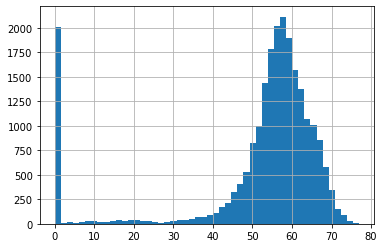

In [30]:
df_full['sum_rougher_metallsinput'].hist(bins=50)

In [31]:
df_full[df_full['sum_rougher_metallsinput']<1]

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery_rougher,recovery_final,MAE_fin,MAE_rou,sum_rougher_metallsinput
date,,,,,,,,,,,,,,,,,,,,,
2016-01-17 01:00:00,7.256114,9.017677,NaN,43.389252,-10254.003046,12.100582,1.75836,4.606019,3.202483,48.760868,...,-492.041563,8.054770,-498.802262,11.961330,-597.272218,0.00000,-10254.003046,NaN,0.0,0.204164
2016-01-19 03:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,2.116168,...,-497.092974,7.953962,-499.698442,11.941642,-598.541756,NaN,NaN,NaN,NaN,0.000000
2016-01-19 04:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,NaN,...,-499.623262,7.979302,-500.283366,11.959950,-600.998301,NaN,NaN,NaN,NaN,0.000000
2016-01-19 05:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,NaN,...,-499.791870,7.978806,-500.202026,11.987839,-600.302819,NaN,NaN,NaN,NaN,0.000000
2016-01-19 06:00:00,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.00000,0.000000,0.000000,NaN,...,-499.842458,8.053455,-499.588522,11.987935,-600.523057,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-07 22:59:59,0.354655,0.531568,0.621536,2.168631,100.000000,0.000000,0.00000,0.000000,0.000000,NaN,...,-544.751277,18.025273,-500.463749,23.002909,-536.657793,-68360.24333,100.000000,0.0,NaN,0.040000
2018-08-07 23:59:59,0.010000,0.010000,0.010000,0.010000,100.000000,0.000000,0.00000,0.000000,0.000000,NaN,...,-539.538899,17.997212,-499.904563,22.987740,-625.612323,NaN,100.000000,0.0,NaN,0.040000
2018-08-08 00:59:59,0.010000,0.010000,0.010000,0.010000,100.000000,0.000000,0.00000,0.000000,0.000000,NaN,...,-499.548578,18.004011,-499.946969,22.988480,-529.571034,NaN,100.000000,0.0,NaN,0.040000


Как видим, у нас есть выброс, где занчения суммы параметров сырья около 0. Можно считать, что это отсутстиве подачи сырья. Удалим их.

In [32]:
df_full=df_full[df_full['sum_rougher_metallsinput']>1]

In [33]:
df_full.isna().mean().sort_values(ascending=False).head(15)

secondary_cleaner.output.tail_sol           0.098923
MAE_rou                                     0.054217
rougher.output.recovery                     0.040651
rougher.output.tail_ag                      0.040651
recovery_rougher                            0.040651
rougher.output.tail_sol                     0.040603
rougher.output.tail_au                      0.040603
primary_cleaner.output.concentrate_sol      0.030367
rougher.input.floatbank11_xanthate          0.025202
rougher.state.floatbank10_e_air             0.024574
MAE_fin                                     0.014822
final.output.concentrate_sol                0.014628
primary_cleaner.output.concentrate_pb       0.014146
rougher.input.feed_sol                      0.012263
secondary_cleaner.state.floatbank2_a_air    0.011683
dtype: float64

In [34]:
df_full['sum_metallsinput_plus_chem']=df_full['sum_rougher_metallsinput']+df_full.loc[:,['rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate']].sum(axis=1)

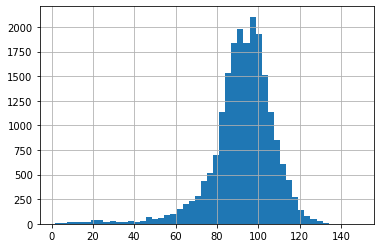

In [35]:
df_full['sum_metallsinput_plus_chem'].hist(bins=50)

Рассмотрим распределение пропукта на выходе из флотации

In [36]:
df_full['sum_rougher_out_total']=df_full.loc[:,['rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au',
       'rougher.output.tail_ag', 'rougher.output.tail_pb',
       'rougher.output.tail_sol', 'rougher.output.tail_au']].sum(axis=1)

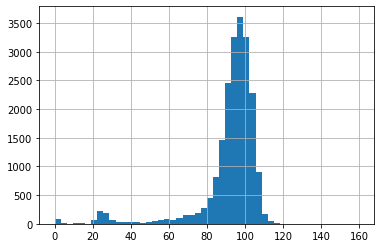

In [37]:
df_full['sum_rougher_out_total'].hist(bins=50)

In [38]:
df_full['sum_rougher_out_cocentr']=df_full.loc[:,['rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au']].sum(axis=1)

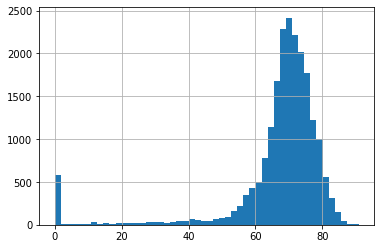

In [39]:
df_full['sum_rougher_out_cocentr'].hist(bins=50)

Отсутствие данных по концентрациям продукта после флотации не позволяет расчитать эффективность. Будет лучше их удалить.

In [40]:
df_full=df_full[df_full['sum_rougher_out_cocentr']>1]

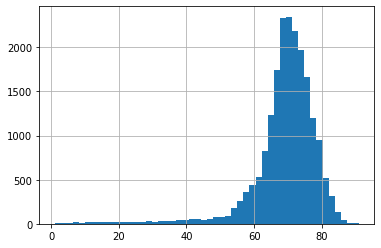

In [41]:
df_full['sum_rougher_out_cocentr'].hist(bins=50)

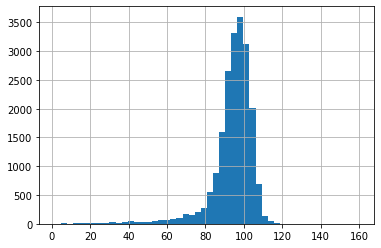

In [42]:
df_full['sum_rougher_out_total'].hist(bins=50)

Как видим то, что мы убрали данный выборс, также он сказался на общей сумме выхода продукта после флотации и убрал выбров в районе 20-30

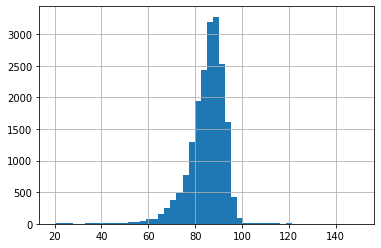

In [43]:
df_full['rougher.output.recovery'].hist(bins=50,range=(20,150))

###### Исследуем теперь первый этап отчистки

In [44]:
df_full['sum_output_primary']=df_full[['primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au']].sum(axis=1)

In [45]:
df_full['sum_output_primary_concentr']=df_full[['primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au']].sum(axis=1)

In [46]:
df_full['sum_input_primary']=df_full[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant', 'primary_cleaner.input.xanthate']].sum(axis=1)

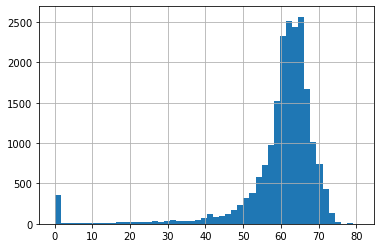

In [47]:
df_full['sum_output_primary_concentr'].hist(bins=50)

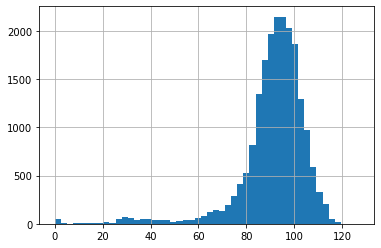

In [48]:
df_full['sum_output_primary'].hist(bins=50)

In [49]:
df_full=df_full[df_full['sum_output_primary_concentr']>10]

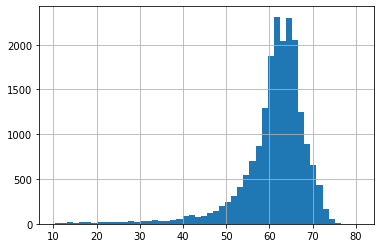

In [50]:
df_full['sum_output_primary_concentr'].hist(bins=50)

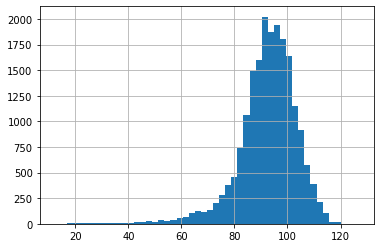

In [51]:
df_full['sum_output_primary'].hist(bins=50)

Мы убрали выбросы на этой стадии, графики стали выглядить лучше

###### Исследуем теперь второй этап отчистки

In [52]:
df_full['sum_secondary_tail']=df_full[['secondary_cleaner.output.tail_ag', 'secondary_cleaner.output.tail_pb',
       'secondary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au']].sum(axis=1)

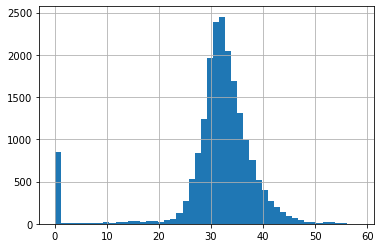

In [53]:
df_full['sum_secondary_tail'].hist(bins=50)

Скорее всего отсутствие данных по отвальным хвостам говорит об ошибках в данных, т.к. совсем их не меожет не быть. Удалим эти данные, чтобы не давать ложные данные модели

In [54]:
df_full=df_full[df_full['sum_secondary_tail']>1]

###### Исследуем теперь финальный этап отчистки

In [55]:
df_full['sum_output_final']=df_full[['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au']].sum(axis=1)

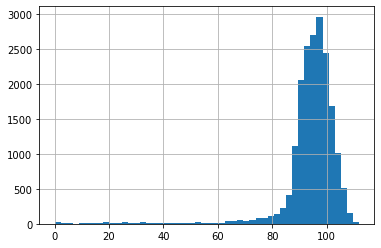

In [56]:
df_full['sum_output_final'].hist(bins=50)

In [57]:
df_full['sum_output_final_concentr']=df_full[['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au']].sum(axis=1)

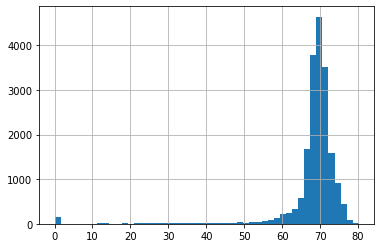

In [58]:
df_full['sum_output_final_concentr'].hist(bins=50)

In [59]:
df_full=df_full[df_full['sum_output_final_concentr']>1]

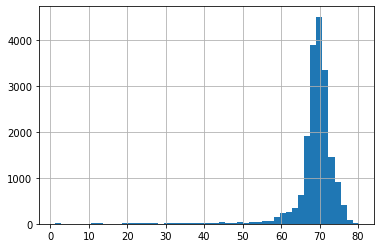

In [60]:
df_full['sum_output_final_concentr'].hist(bins=50)

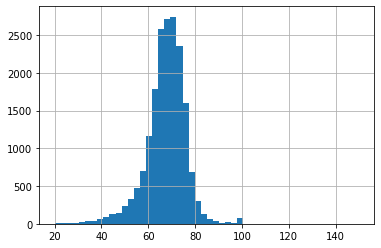

In [61]:
df_full['final.output.recovery'].hist(bins=50,range=(20,150))

100% эффективности у нас также не может быть при отчитске. Скорее всго это тоже выбросы, уберем их.

In [62]:
df_full=df_full[df_full['final.output.recovery']<90]

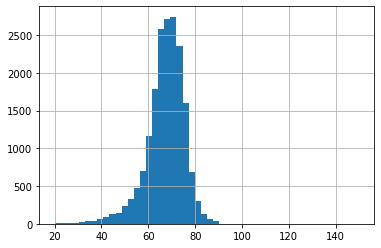

In [63]:
df_full['final.output.recovery'].hist(bins=50,range=(20,150))

##### Мы провели анализ всех стадий, отчистили их от выбросов.

In [64]:
df_full.isna().mean().sort_values(ascending=False).head(15)

secondary_cleaner.output.tail_sol           0.096920
MAE_rou                                     0.039899
rougher.output.tail_ag                      0.030691
recovery_rougher                            0.030638
rougher.output.recovery                     0.030638
rougher.output.tail_sol                     0.030638
rougher.output.tail_au                      0.030638
primary_cleaner.output.concentrate_sol      0.023207
rougher.state.floatbank10_e_air             0.021053
final.output.concentrate_sol                0.014107
secondary_cleaner.state.floatbank2_a_air    0.011200
rougher.input.floatbank11_xanthate          0.008615
primary_cleaner.output.concentrate_pb       0.007592
rougher.input.feed_size                     0.006515
rougher.input.feed_sol                      0.005169
dtype: float64

Как видим, у нас все еще много пропусков. Удалим пропуски.

In [65]:
df_full.isna().mean().sort_values(ascending=False).head(15)

secondary_cleaner.output.tail_sol           0.096920
MAE_rou                                     0.039899
rougher.output.tail_ag                      0.030691
recovery_rougher                            0.030638
rougher.output.recovery                     0.030638
rougher.output.tail_sol                     0.030638
rougher.output.tail_au                      0.030638
primary_cleaner.output.concentrate_sol      0.023207
rougher.state.floatbank10_e_air             0.021053
final.output.concentrate_sol                0.014107
secondary_cleaner.state.floatbank2_a_air    0.011200
rougher.input.floatbank11_xanthate          0.008615
primary_cleaner.output.concentrate_pb       0.007592
rougher.input.feed_size                     0.006515
rougher.input.feed_sol                      0.005169
dtype: float64

In [66]:
df_full=df_full.dropna()

###### Обновим данные обучающей и тестовой выборки по исправленной полной таблице. 

In [67]:
df_test_new=df_full.loc[df_test.index].dropna()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [68]:
df_test_new=df_test_new.loc[:,df_test.columns]

In [69]:
df_test_new.shape

(4806, 52)

In [70]:
#df_test_new=df_test.dropna()

In [71]:
df_train_new=df_full.loc[df_train.index].dropna()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [72]:
df_train_new=df_train_new.loc[:,df_train.columns]

In [73]:
df_train_new.shape

(10232, 86)

In [74]:
df_full.shape

(15038, 100)

# 3. Модель

Мы имеем подготовленные таблицы, выделим из них параметры и целевые параметры для rough и final эффективности

In [75]:
train_target_rougher=df_train_new['rougher.output.recovery'].reset_index(drop=True)

In [76]:
train_target_final=df_train_new['final.output.recovery'].reset_index(drop=True)

In [77]:
train_features_rougher=df_train_new.loc[:,('rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate')]

выделим в обучающей выборке только те признаки, что есть в тестовой

In [78]:
train_features_final=df_train_new.loc[:,(df_test_new.columns)]

In [79]:
test_features_final=df_test_new

In [80]:
train_features_rougher=df_train_new.loc[:,('rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level')]

In [81]:
test_features_rougher=df_test_new.loc[:,('rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level')]

In [82]:
test_target_final=df_full['final.output.recovery'].loc[test_features_final.index].dropna().reset_index(drop=True)

In [83]:
test_target_rougher=df_full['rougher.output.recovery'].loc[test_features_rougher.index].dropna().reset_index(drop=True)

In [84]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
import numpy as np
from tqdm.notebook import tqdm

In [85]:
def log_progress(sequence, every=10):
    from ipywidgets import IntProgress
    from IPython.display import display

    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [86]:
def smape(y_pred, y_true):
    return 100/len(y_pred) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_pred) + np.abs(y_true)))

In [87]:
def smape_total(smape_rougher,smape_final):
    return smape_rougher*0.25 + smape_final*0.75

Посчитаем минимальное значение целевой метрики для условия, если наша модель определяет значение равное средним по выборке

In [88]:
mean_final=[train_target_final.median()]*len(train_target_final)

In [89]:
mean_rougher=[train_target_rougher.median()]*len(train_target_rougher)

In [90]:
smape_rougher=smape(mean_rougher,train_target_rougher)

In [91]:
smape_rougher

6.9281856681455265

In [92]:
smape_final=smape(mean_final,train_target_final)

In [93]:
smape_final

8.862940681264842

In [94]:
smape_stand=smape_total(smape_rougher,smape_final)

In [95]:
smape_stand

8.379251927985013

В дальнейшем будем орентироваться на 8.37 как на минимальный скор

Создадим метрику sMAPE для наших моделей

In [96]:
score = make_scorer(smape, greater_is_better=True)

Выделим модели, которые будем в дальнейшем рассматривать

In [97]:
RF=RandomForestRegressor(random_state=42)

In [98]:
LR=LinearRegression()

In [99]:
DT=DecisionTreeRegressor(random_state=42)

###### Сделаем рассчет эффективности для финальной стадии

Случайный лес

In [100]:
RF_CV_f=cross_val_score(RF, train_features_final, train_target_final, scoring=score, cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [101]:
RF_CV_f.mean()

9.535907011574164

Линейная регрессия

In [102]:
LR_CV_f=cross_val_score(LR, train_features_final, train_target_final, scoring=score, cv=5)

In [103]:
LR_CV_f

array([10.39210388,  7.95971635,  6.66524106,  9.06659329, 11.64841181])

In [104]:
LR_CV_f.mean()

9.146413280138447

Дерево решений

In [105]:
DT_CV_f=cross_val_score(DT, train_features_final, train_target_final, scoring=score, cv=5)

In [106]:
DT_CV_f

array([15.01423218, 12.47793503, 13.72366619, 12.40497295, 14.59672621])

In [107]:
DT_CV_f.mean()

13.64350650946597

###### Эффективность на флотации

Случайный лес

In [108]:
RF_CV_r=cross_val_score(RF, train_features_rougher, train_target_rougher, scoring=score, cv=5)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [109]:
RF_CV_r

array([7.94768532, 6.59924035, 5.50972026, 5.08129981, 6.9433148 ])

In [110]:
RF_CV_r.mean()

6.416252105414732

Линейная регрессия

In [111]:
LR_CV_r=cross_val_score(LR, train_features_rougher, train_target_rougher, scoring=score, cv=5)

In [112]:
LR_CV_r

array([7.07201903, 6.70035209, 4.11130381, 5.15480991, 8.37461999])

In [113]:
LR_CV_r.mean()

6.282620966353811

Дерево решений

In [114]:
DT_CV_r=cross_val_score(DT, train_features_rougher, train_target_rougher, scoring=score, cv=5)

In [115]:
DT_CV_r

array([11.69608576, 10.77140579,  6.30503488,  6.13811056,  9.16351268])

In [116]:
DT_CV_r.mean()

8.814829934112728

In [117]:
pd.DataFrame(np.array([[RF_CV_r.mean(),LR_CV_r.mean(),DT_CV_r.mean()],
                       [RF_CV_f.mean(),LR_CV_f.mean(),DT_CV_f.mean()]]),
             columns=['RandomForestRegressor','LinearRegression','DecisionTreeRegressor'],
             index=['rougher','final']).T

,rougher,final
RandomForestRegressor,6.416252,9.535907
LinearRegression,6.282621,9.146413
DecisionTreeRegressor,8.814830,13.643507


Как видим у нас безоговорочный лидер это линейная регрессия, рассчитем итоговую метрику и применим данную модель уже на тестовой выборке

###### Итогое sMAPE

In [118]:
smape_stand

8.379251927985013

In [119]:
smape_total(LR_CV_r.mean(),LR_CV_f.mean())

8.430465201692288

### Тест

In [121]:
LR.fit(train_features_rougher,train_target_rougher)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [122]:
prediction_r=LR.predict(test_features_rougher)

In [123]:
prediction_r

array([94.74600065, 93.85773196, 94.37517374, ..., 94.36468187,
       94.32285703, 92.87086526])

In [124]:
LR.fit(train_features_final,train_target_final)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [125]:
prediction_f=LR.predict(test_features_final)

In [126]:
prediction_f

array([72.44448112, 72.47667281, 72.89891831, ..., 73.01032598,
       73.70713213, 73.09808614])

In [127]:
smape_f=smape( pd.Series(prediction_f), test_target_final) 

In [128]:
test_target_final

0       70.273583
1       68.910432
2       68.143213
3       67.776393
4       61.467078
          ...    
4801    68.919891
4802    68.440582
4803    67.092759
4804    68.061186
4805    71.699976
Name: final.output.recovery, Length: 4806, dtype: float64

In [129]:
smape_f

7.473745496920835

In [130]:
smape_r=smape( pd.Series(prediction_r), test_target_rougher)

In [131]:
smape_r

4.171089735647895

In [132]:
smape_total(smape_r,smape_f)

6.6480815566026

### Вывод

- Мы изучили данные, провели их предобработку,
- Выделили признаки для обучения модели на rougher и final стадиях,
- Провели кросс-валидацию моделей, выбрали лучшей моделью линейную регрессию,
- Оценили ее на тестовой выборке и получили SMAPE=6.64